## Titanic Solution

In [1]:
from titanic_utils import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.pipeline import Pipeline, FeatureUnion
from preprocessing import *

In [2]:
X_train, X_test, y_train = import_data()
data = pd.concat([X_train, y_train], axis = 1)

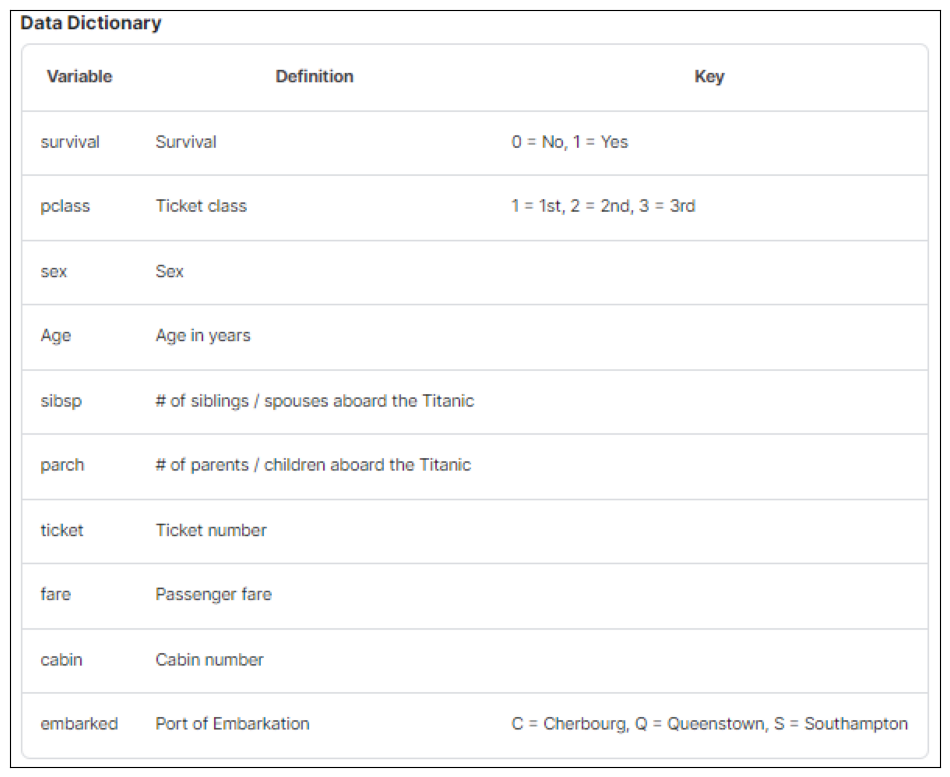

In [3]:
plt.figure(figsize=(12, 10))
plt.imshow(mpimg.imread("images/data_dict.png"))
plt.xticks([])
plt.yticks([])
plt.show()

Columns to drop: PassengerId and Ticket.

In [4]:
num_cols = get_num_cols(X_train)
cat_cols = get_cat_cols(X_train)

print(f"num_cols: {num_cols}\ncat_cols: {cat_cols}")

num_cols: Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')
cat_cols: Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')


In [5]:
num_pipeline = Pipeline([
    ('selector', DataFrameSelector('num')),
    ('dropper', ColumnDropper(['PassengerId'])),
    ('imputer', ImputerTransformer(strategy='most_frequent')),
    ('age_classifier', AgeClassifier()),
    ('fare_classifier', FareClassifier()),
    ('alone_extractor', AloneExtractor()),
    ('scaler', ScalerTransformer(strategy='standard'))
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector('cat')),
    ('dropper', ColumnDropper(['Ticket'])), 
    ('cabin_classifier', CabinClassifier(True)),
    ('embark_classifier', EmbarkClassifier(False)),
    ('sex_extractor', SexExtractor()),
    ('title_extractor', TitleExtractor()),
    ('scaler', ScalerTransformer(strategy='standard'))
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])


In [6]:
full_pipeline

FeatureUnion(transformer_list=[('num_pipeline',
                                Pipeline(steps=[('selector',
                                                 DataFrameSelector(type='num')),
                                                ('dropper',
                                                 ColumnDropper(columns_names=['PassengerId'])),
                                                ('imputer',
                                                 ImputerTransformer(strategy='most_frequent')),
                                                ('age_classifier',
                                                 AgeClassifier()),
                                                ('fare_classifier',
                                                 FareClassifier()),
                                                ('alone_extractor',
                                                 AloneExtractor()),
                                                ('scaler',
                                                 ScalerTrans...))])),
                               ('cat_pipeline',
                                Pipeline(steps=[('selector',
                                                 DataFrameSelector(type='cat')),
                                                ('dropper',
                                                 ColumnDropper(columns_names=['Ticket'])),
                                                ('cabin_classifier',
                                                 CabinClassifier()),
                                                ('embark_classifier',
                                                 EmbarkClassifier(ordinal=False)),
                                                ('sex_extractor',
                                                 SexExtractor()),
                                                ('title_extractor',
                                                 TitleExtractor()),
                                                ('scaler',
                                                 ScalerTransformer(strategy='standard'))]))])

Importance decrescent order (according to GPT):

16 - Sir
15 - theCountess
14 - Don
13 - Capt (Captain)
12 - Rev (Reverend)
11 - Col (Colonel)
10 - Lady
9 - Major
8 - Dr (Doctor)
7 - Mlle (Mademoiselle)
6 - Ms
5 - Mme (Madame)
4 - Mrs
3 - Miss
2 - Master
1 - Mr
0 - Jonkheer

"1st Class passengers were put up in cabins with decks A, B, C, D, and E, while second class passengers were put up in cabins in decks D and E primarily, while further decks had cabins for 3rd Class passengers."

https://medium.com/analytics-vidhya/titanic-dataset-analysis-80-accuracy-9480cf3db538

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [8]:
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)

In [9]:
param_grid = [
    {'n_estimators': [5, 10, 20, 40, 80], 
     'max_depth': [None, 10, 20, 40, 80],
     'min_samples_split': [2, 4, 8, 16],
     'min_samples_leaf': [1, 2, 5, 10]}
]

estimator = RandomForestClassifier()

grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5,scoring='accuracy', n_jobs=1, verbose=20)
grid_search.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
[CV 1/5; 1/400] START max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=5
[CV 1/5; 1/400] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=5;, score=0.804 total time=   0.0s
[CV 2/5; 1/400] START max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=5
[CV 2/5; 1/400] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=5;, score=0.775 total time=   0.0s
[CV 3/5; 1/400] START max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=5
[CV 3/5; 1/400] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=5;, score=0.831 total time=   0.0s
[CV 4/5; 1/400] START max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=5
[CV 4/5; 1/400] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=5;, score=0.803 total time=   0.0s
[CV 5/5; 1/400] START max_depth=None, min_samples_leaf=1, mi

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=1,
             param_grid=[{'max_depth': [None, 10, 20, 40, 80],
                          'min_samples_leaf': [1, 2, 5, 10],
                          'min_samples_split': [2, 4, 8, 16],
                          'n_estimators': [5, 10, 20, 40, 80]}],
             scoring='accuracy', verbose=20)

In [10]:
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

In [11]:
best_params

{'max_depth': 80,
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'n_estimators': 80}

In [12]:
best_estimator

RandomForestClassifier(max_depth=80, min_samples_leaf=2, min_samples_split=8,
                       n_estimators=80)

In [13]:
prediction = pd.DataFrame(best_estimator.predict(X_test_prepared), columns=['Survived'])
submission = pd.concat([X_test['PassengerId'], prediction], axis=1)
submission.to_csv("data/submission_v1.csv", index=False)